### Time Decay

시장은 적응적 시스템이다(Lo, 2017). 시장이 발달할수록 과거의 사건은 새로운 것보다 더 연관성이 떨어진다. 결론적으로 대개는 새로운 관측값을 얻게 되면 표본 가중값을 감쇠시키려고 한다. $d[x] \geq 0, \forall x \in \left[ 0, \sum_{i=1}^I \bar{u_i}\right]$를 Return attribution에 곱하게 될 시간 감쇠 요인이라고 하자. 마지막 가중값에는 감쇠가 없다. $d\left[ \sum_{i=1}^I \bar{u_i}\right] = 1$이고, 모든 다른 가중값은 이에 상대적으로 수정될 것이다. $c \in (-1, 1]$이 다음과 같이 감쇠 함수를 결정하는 사용자 정의 parameter라고 가정해 보자. 

- $c \in [0, 1]$이면, $d[1] = c$이고 선형감쇠이다. 
- $c \in (-1, 0)$이면, $d\left[\sum_{i=1}^I\bar{u_i}\right] = 0$이고 $\left[-c\sum_{i=1}^I\bar{u_i}, \sum_{i=1}^I\bar{u_i}\right]$ 사이에서 선형 감쇠이며, $d[x] = 0 ~~ \forall x \leq -c\sum_{i=1}^I\bar{u_i}$이다.


선형구간함수 $d = \max \{0, a+bx\}$에서 다음 경계 조건에 의해 이런 요구 조건들이 성립한다.

1. $d = a + b\sum_{i=1}^I \bar{u_i} = 1 \Rightarrow 1 - b\sum_{i=1}^I \bar{u_i}$
2. $c$에 따라서
    - $d = a+ b0 = c \Rightarrow b = (1-c)\left( \sum_{i=1}^I \bar{u_i} \right)^{-1}, ~~ \forall c \in [0,1]$
    - $d = a - bc\sum_{i=1}^I\bar{u_i} = 0 \Rightarrow b = \left[ (c_1) \sum_{i=1}^I \bar{u_i}\right]^{-1}, ~~\forall c\in (-0, 1)$

아래 코드는 이런 형태의 Time decay factor를 구현하고 있다. 시간이 발생순서를 의미하지 않는다는 점에 주목하자. 이 구현에 있어서 감쇠는 누적 고유도 $x = \left[ 0, \sum_{i=1}^I \bar{u_i}\right]$에 의해 발생한다. 발생 순서상의 감쇠는 중복된 관측값이 있을 경우에는 가중치를 너무 빠르게 줄인다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

start_date = '2000-01-01'
end_date = '2024-04-08'
ticker = 'AAPL'
data = yf.download(
    ticker, 
    start = start_date, 
    end = end_date
)

triple_barrier_events = pd.read_parquet('triple_barrier_events.parquet')

[*********************100%%**********************]  1 of 1 completed


In [2]:
from FinancialMachineLearning.sample_weights.attribution import weights_by_time_decay
time_decay = weights_by_time_decay(
    triple_barrier_events = triple_barrier_events[:-10],
    close_series = data['Close'],
    num_threads = 1,
    decay = 0.5
)

In [3]:
time_decay.head()

Date
2000-01-07    0.500419
2000-01-10    0.500686
2000-01-11    0.500915
2000-01-12    0.501201
2000-01-13    0.501472
Name: tW, dtype: float64

In [4]:
time_decay_factor = pd.DataFrame(index = time_decay.index)
for decay in [1.0, 0.75, 0.5, 0, -0.25, -0.5] :
    rsuffix = f'_decay_{decay}'
    time_decay_factor = time_decay_factor.join(
        weights_by_time_decay(
        triple_barrier_events = triple_barrier_events[:-10],
        close_series = data['Close'],
        num_threads = 1,
        decay = decay
        ),
        rsuffix = rsuffix
    )   

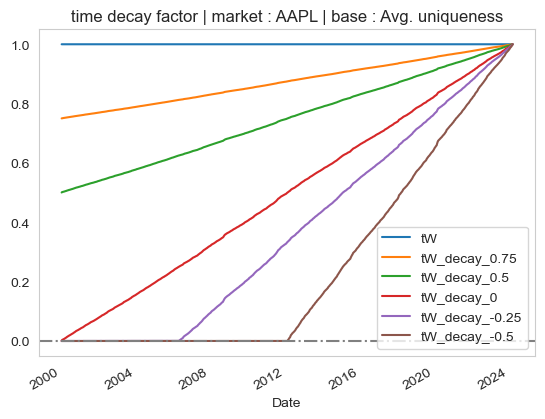

In [5]:
time_decay_factor.plot()
plt.title('time decay factor | market : AAPL | base : Avg. uniqueness')
plt.grid(False)
plt.axhline(0, ls = '-.', color = 'gray')
plt.show()